In [ ]:
!pip install tensorflow==2.9.1

In [ ]:
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

In [ ]:
! kaggle datasets download -d janmejaybhoi/cotton-disease-dataset

 94% 139M/148M [00:02<00:00, 52.2MB/s]
100% 148M/148M [00:02<00:00, 61.8MB/s]


In [ ]:
!unzip cotton-disease-dataset.zip

Archive:  cotton-disease-dataset.zip
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (124).jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (153)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (173)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (175)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (183)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (193)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (194)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (204)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (206)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (214)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (219)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (224)_iaip.jpg  
  inflat

In [ ]:
# Configure GPU options
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# Load ResNetV2 base model
base_model = ResNet152V2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output of the base ResNetV2 model
x = Flatten()(base_model.output)

In [ ]:
# Define the number of classes based on your dataset
NUM_CLASSES = 4  # Update with the actual number of classes in your dataset


In [ ]:
# Add a fully connected layer with 128 neurons
x = Dense(128, activation='relu')(x)

In [ ]:
# Add the final classification layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


In [ ]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/Cotton Disease/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')


Found 1951 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/Cotton Disease/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')


Found 106 images belonging to 4 classes.


In [ ]:
# Fit the model
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/20
61/61 [==============================] - 60s 656ms/step - loss: 1.4169 - accuracy: 0.8109 - val_loss: 0.6138 - val_accuracy: 0.8868
Epoch 2/20
61/61 [==============================] - 34s 549ms/step - loss: 0.2919 - accuracy: 0.9216 - val_loss: 0.3432 - val_accuracy: 0.9151
Epoch 3/20
61/61 [==============================] - 34s 560ms/step - loss: 0.1773 - accuracy: 0.9405 - val_loss: 0.4008 - val_accuracy: 0.9528
Epoch 4/20
61/61 [==============================] - 35s 575ms/step - loss: 0.1654 - accuracy: 0.9518 - val_loss: 0.2197 - val_accuracy: 0.9245
Epoch 5/20
61/61 [==============================] - 34s 551ms/step - loss: 0.1464 - accuracy: 0.9575 - val_loss: 0.1777 - val_accuracy: 0.9245
Epoch 6/20
61/61 [==============================] - 35s 559ms/step - loss: 0.0890 - accuracy: 0.9723 - val_loss: 0.0910 - val_accuracy: 0.9528
Epoch 7/20
61/61 [==============================] - 35s 563ms/step - loss: 0.0872 - accuracy: 0.9723 - val_loss: 0.1821 - val_accuracy: 0.9340

In [ ]:
import matplotlib.pyplot as plt

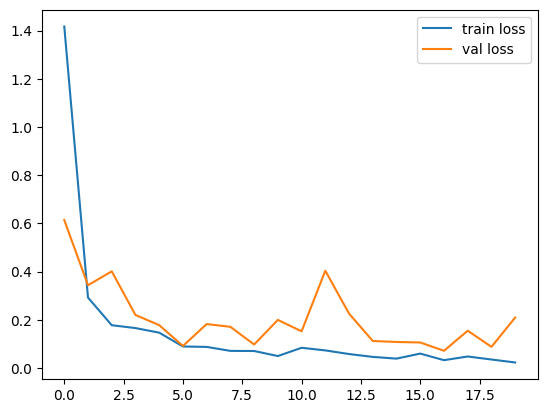

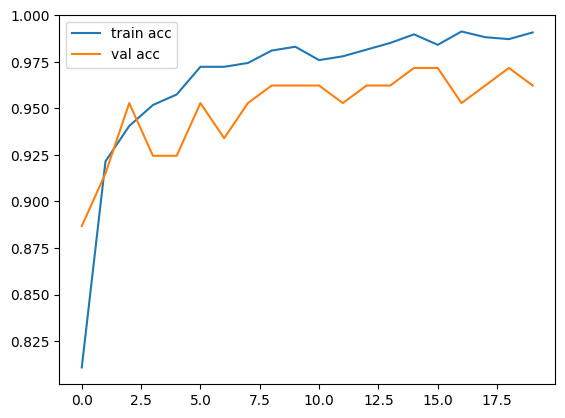

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Use the model to predict the test set
predictions = model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_set.classes


4/4 [==============================] - 5s 617ms/step


In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

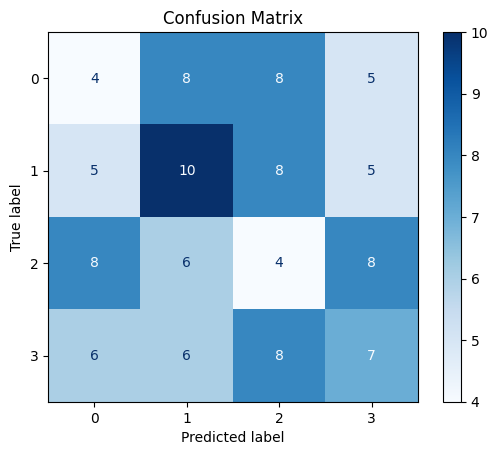

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(NUM_CLASSES))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50_v2.h5')

In [ ]:
y_pred = model.predict(test_set)

4/4 [==============================] - 4s 518ms/step


In [ ]:
y_pred

array([[4.31669172e-08, 6.56898749e-08, 9.99999523e-01, 3.64499755e-07],
       [9.99999881e-01, 8.63577476e-09, 7.72220119e-08, 3.55166480e-10],
       [4.34130787e-11, 9.86008942e-01, 3.64178868e-14, 1.39911100e-02],
       [9.99999881e-01, 3.05585196e-21, 1.76968896e-07, 1.74987587e-20],
       [9.97980177e-01, 8.49190870e-16, 2.01984798e-03, 3.17792193e-14],
       [3.36432313e-05, 2.77257040e-09, 9.99965787e-01, 5.62632465e-07],
       [1.64793222e-04, 1.93207035e-21, 9.99835134e-01, 4.05726791e-19],
       [9.93910909e-01, 1.40580866e-10, 6.08907174e-03, 8.37732905e-09],
       [1.18755974e-08, 8.43230039e-02, 5.56653568e-08, 9.15676832e-01],
       [9.99820888e-01, 8.05771421e-19, 1.79157068e-04, 5.30168427e-18],
       [3.39165375e-14, 9.99999881e-01, 6.28224211e-14, 9.41881879e-08],
       [1.35365966e-07, 1.60369288e-15, 9.99999881e-01, 2.80433635e-13],
       [2.78364372e-04, 5.26361167e-03, 3.67260864e-03, 9.90785360e-01],
       [9.99912620e-01, 1.58833660e-18, 8.74302787e

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([2, 0, 1, 0, 0, 2, 2, 0, 3, 0, 1, 2, 3, 0, 2, 0, 3, 1, 3, 3, 3, 0,
       2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 1, 3, 2, 0, 1,
       0, 0, 0, 2, 0, 2, 3, 1, 1, 3, 1, 0, 1, 3, 3, 2, 1, 3, 1, 0, 3, 3,
       3, 3, 2, 1, 1, 3, 0, 1, 1, 1, 2, 0, 1, 2, 1, 0, 0, 2, 1, 3, 2, 0,
       1, 2, 2, 3, 3, 3, 3, 2, 0, 1, 3, 3, 3, 1, 2, 3, 1, 1])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename

In [ ]:
# Define a flask app
app = Flask(__name__)

In [ ]:
model=load_model('model_resnet50_v2.h5')

In [ ]:
def model_predict(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Rescale to [0, 1] as done during training

    # Make a prediction using the model
    prediction = model.predict(img)

    return prediction

In [ ]:
model=load_model('model_resnet50.h5')
image_path = '/content/Cotton Disease/test/diseased cotton plant/dd (188)_iaip.jpg'
result = model_predict(image_path, model)
print(result)

In [ ]:
img=image.load_img('/content/Cotton Disease/test/diseased cotton leaf',target_size=(224,224))

In [ ]:
x=image.img_to_array(img)
x

In [ ]:
x.shape

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

In [ ]:
model.predict(img_data)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

In [ ]:
a==1

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__